# Amazon Shure MV7 EDA and Sentement Analysis

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [Fastpages, Jupyter, Python, Selenium, Stoc]
- annotations: true
- hide: false
- image: images/diagram.png
- layout: post
- search_exclude: true

### Required Packages

[wordcloud](https://github.com/amueller/word_cloud), 
[geopandas](https://geopandas.org/en/stable/getting_started/install.html), 
[nbformat](https://pypi.org/project/nbformat/), 
[seaborn](https://seaborn.pydata.org/installing.html), 
[scikit-learn](https://scikit-learn.org/stable/install.html)

### Now let's get started!
First thing first, you need to load all the necessary libraries:

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import re
import plotly.graph_objects as go
import seaborn as sns

## Read the Data

In [ ]:
#Import Data
df = pd.read_csv("/Users/zeyu/Desktop/DS/Ebay & Amazon/Amazon_reviews_scraping/Amazon_reviews_scraping/full_reviews.csv")

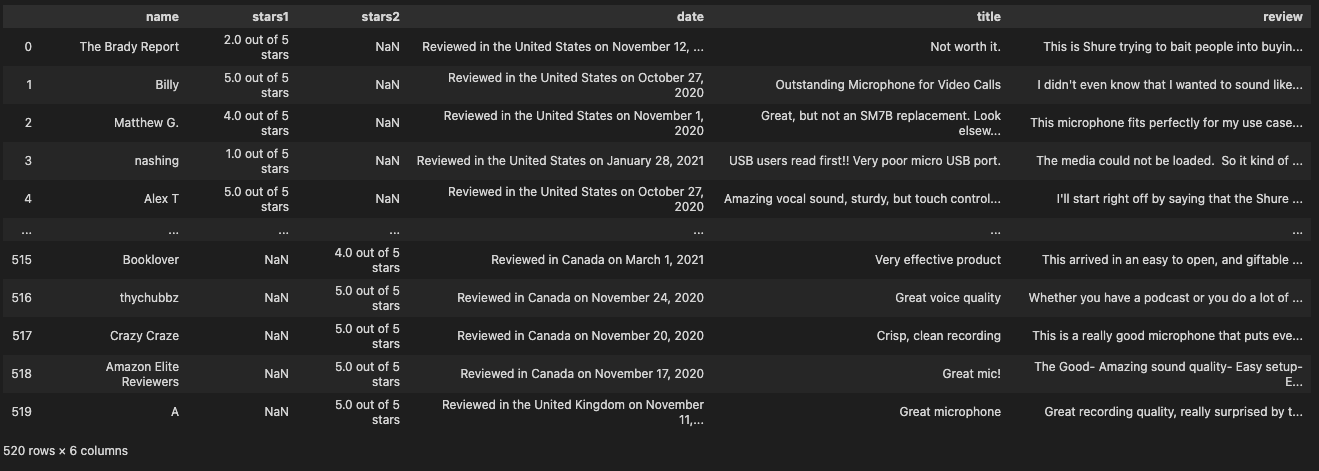

## Data Cleaning

Step 1:
- Splite column Date to Country and Date
- Combine the two rating columns to one
- Convert type of date from string to datetime

In [ ]:
#Clean Data
info = []
for i in df["date"]:
    x = re.sub("Reviewed in ", "", i)
    x1 = re.sub(" on ", "*", x)
    info.append(x1)

df["date"] = pd.DataFrame({"date": info})
df[['country','date']] = df.date.apply(
   lambda x: pd.Series(str(x).split("*")))

star = []
star = df.stars1.combine_first(df.stars2)
df["star"] = pd.DataFrame({"star": star})

del df['stars1']
del df['stars2']

#Convert String to Date
df.date = pd.to_datetime(df.date)

Step 2:
- Two methods to verify if column "star" contain any NaN
- Converted the type of column "star" from string to Int

In [ ]:
"nan" in df['star']

In [ ]:
df_no_star = df[df['star'].isna()]
df_no_star

In [ ]:
#Convert 2.0 out of 5 stars to 2
df_int = []
#df_with_star["stars"] = [str(x).replace(':',' ') for x in df["stars"]]

for i in df["star"]:
    x = re.sub(".0 out of 5 stars", "", i)
    df_int.append(x)

df["rating"] = pd.DataFrame({"rating": df_int})
df["rating"] = df["rating"].astype(int)
del df['star']

This is the data looks like after cleaning.
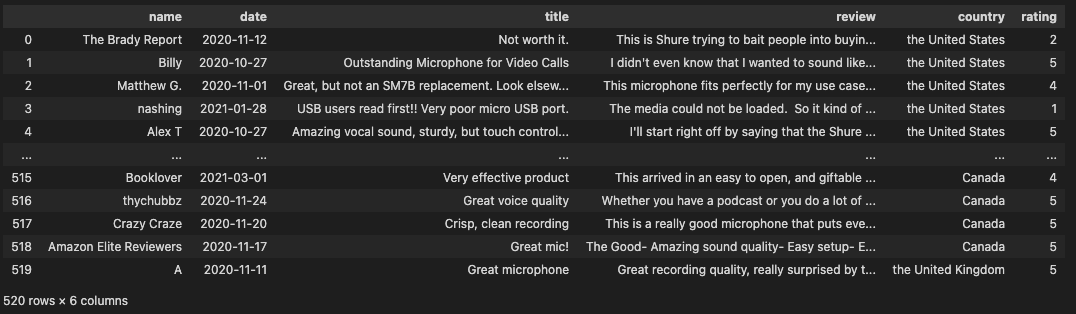

## EDA

In [ ]:
temp = df['rating'].value_counts()
fig = go.Figure(go.Bar(
            x=temp,
            y=temp.index,
            orientation='h'))

fig.show()

In [ ]:
df_country = df['country'].value_counts()
fig = go.Figure(go.Bar(
            x=df_country,
            y=df_country.index,
            orientation='h'))

fig.show()

In [ ]:
mean_rating = df['rating'].mean()
mean_rating

In [ ]:
"""fig = px.line(df, x=temp.index, y=temp.rating, title='Life expectancy in Canada')
fig.show()"""
import plotly.express as px
temp = df.groupby([df['date'].dt.date]).mean()
temp

In [ ]:
#Average rating each month
temp = df.groupby(df['date'].dt.strftime('%B'))['rating'].mean().sort_values()
order_temp = temp.reindex(["January", "February", "March", "April", "May", "June", "July", "August", "September", "November", "December"])
order_temp.plot()

In [ ]:
#Quantity of reviews in each month.
temp = df.groupby(df['date'].dt.strftime('%B'))['rating'].count().sort_values()
order_temp = temp.reindex(["January", "February", "March", "April", "May", "June", "July", "August", "September", "November", "December"])
order_temp.plot()

In [ ]:
#Many words are useless so create a stopword list
stopwords = set(STOPWORDS)
stopwords.update(["Mic", "Microphone", "using","sound","use"])


def cleaned_visualise_word_map(x):
    words=" "
    for msg in x:
        msg = str(msg).lower()
        words = words+msg+" "
    wordcloud = WordCloud(stopwords = stopwords, width=3000, height=2500, background_color='white').generate(words)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 14
    fig_size[1] = 7
    #Display image appear more smoothly
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show(wordcloud)
cleaned_visualise_word_map(df["review"])

In [ ]:
df = df[df['rating'] != 3]
df['sentiment'] = df['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [ ]:
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]

In [ ]:
df['sentimentt'] = df['sentiment'].replace({-1 : 'negative'})
df['sentimentt'] = df['sentimentt'].replace({1 : 'positive'})
fig = px.histogram(df, x="sentimentt")
fig.update_traces(marker_color="indianred",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Product Sentiment')
fig.show()

In [ ]:
stopwords = set(STOPWORDS)
#stopwords.update(["Mic", "Microphone", "using", "sound", "use"]) 

## good and great removed because they were included in negative sentiment
pos = " ".join(review for review in positive.title)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
pos = " ".join(review for review in negative.title)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis

In [ ]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final

df['review'] = df['review'].apply(remove_punctuation)
df = df.dropna(subset=['title'])
df['title'] = df['title'].apply(remove_punctuation)

In [ ]:
dfNew = df[['title','sentiment']]
dfNew.head()

In [ ]:
dfLong = df[['review','sentiment']]
dfLong.head()

In [ ]:
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

In [ ]:
#change df frame to a bag of words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')

[Vectorizer](https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af) &
[Bag-of-Words](https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af)


In [ ]:
train_matrix = vectorizer.fit_transform(train['title'])
test_matrix = vectorizer.transform(test['title'])

In [ ]:
train_matrix_l = vectorizer.fit_transform(train['review'])
test_matrix_l = vectorizer.transform(test['review'])

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']

In [ ]:
X_train_l = train_matrix_l
X_test_l = test_matrix_l
y_train_l = train['sentiment']
y_test_l = test['sentiment']

In [ ]:
lr.fit(X_train,y_train)

In [ ]:
lr.fit(X_train_l,y_train_l)

In [ ]:
predictions = lr.predict(X_test)

In [ ]:
predictions_l = lr.predict(X_test_l)

In [96]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[  0,   0],
       [ 13, 103]])

In [97]:
long = np.asarray(y_test_l)
confusion_matrix(predictions_l,y_test_l)

array([[  0,   0],
       [ 13, 103]])

In [98]:
print(classification_report(predictions,y_test))
#0.88 Accuracy

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.89      0.94       116

    accuracy                           0.89       116
   macro avg       0.50      0.44      0.47       116
weighted avg       1.00      0.89      0.94       116



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [99]:
print(classification_report(predictions_l,y_test_l))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.89      0.94       116

    accuracy                           0.89       116
   macro avg       0.50      0.44      0.47       116
weighted avg       1.00      0.89      0.94       116



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

